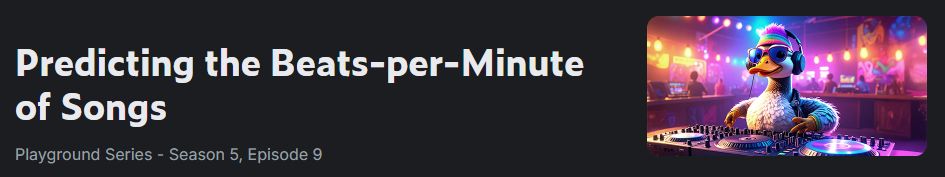
* https://www.kaggle.com/competitions/playground-series-s5e9
* 위 공모전의 목표: 주어진 노래의 여러 특징(feature)들을 기반으로 해당 곡의 BPM(박자 수) 을 예측하는 것

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings(action='ignore')

# scikit-learn
import sklearn

# 수치형 변환
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# PCA (차원 축소 : 주성분분석)
from sklearn.decomposition import PCA

# 문제지, 답안지 분리
from sklearn.model_selection import train_test_split

# 회귀 모델 (+ 통계)
# from sklearn.linear_model import LogisticRegression --> 분류 모델 / 회귀 XXXXXXXX
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# 외부(Google) 회귀모델 (+ 별도설치 )
# import xgboost as xgb
# import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 정규화 / 스케일러
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# 교차 검증 : StratifiedKFold (y를 고르게 폴드에 분배한다는 것은 회귀에서 없다) 
from sklearn.model_selection import KFold, cross_validate, GridSearchCV

# 회귀 평가 매트릭스
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV

# 앙상블
from sklearn.ensemble import StackingRegressor

# 파이프라인
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

# 피쳐 셀렉션
from sklearn.feature_selection import SelectFromModel

# 튜닝
# from pycaret.regression import *

# matplotlib 차트 스타일을 seaborn 스타일로 설정
sns.set()

# ----------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

# Data Load

In [36]:
df = pd.read_csv('../data/train.csv')
df.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


# EDA

| 약어 (Abbr.) | 전체 이름 (Full Name)           | 한 줄 요약 설명 |
|:-------------:|:--------------------------------:|:----------------|
| <font color=yellow>---</font> | <font color=yellow>기본 피쳐</font> | <font color=yellow>---</font> |
| **rs**  | RhythmScore | 리듬의 복잡성이나 규칙성을 나타내는 점수 |
| **al**  | AudioLoudness | 노래의 전체적인 평균 음량 (데시벨) |
| **vc**  | VocalContent | 노래에서 보컬(목소리)이 차지하는 비중 |
| **aq**  | AcousticQuality | 음악이 얼마나 '어쿠스틱'한지(전자음이 적은지) 나타내는 척도 |
| **is**  | InstrumentalScore | 노래에서 악기 연주가 차지하는 비중 |
| **lpl** | LivePerformanceLikelihood | 이 곡이 라이브 공연일 가능성 |
| **ms**  | MoodScore | 곡의 전반적인 분위기(예: 긍정, 부정)를 나타내는 점수 |
| **tdm** | TrackDurationMs | 노래의 총 길이 (밀리초 단위) |
| **e**   | Energy | 노래의 에너지 레벨, 즉 강렬하고 활기찬 정도 |
| **bpm** | BeatsPerMinute | (타겟 변수) 1분당 비트 수, 즉 노래의 빠르기 |
| <font color=yellow>---</font> | <font color=yellow>파생 피쳐</font> | <font color=yellow>---</font> |
| **tdn** | TrackDurationMin | tdm(밀리초)을 분(minute) 단위로 변환한 노래의 길이 |
| **ear** | Energy_Acoustic_Ratio | 에너지 대비 어쿠스틱함의 비율로, 전자음악/어쿠스틱 성향을 나타냄 |
| **vib** | Vocal_Instrument_Balance | 보컬과 악기 사운드의 균형을 나타내는 지표 |
| **mr**  | MoodRhythm | 분위기(Mood)와 리듬감(Rhythm)의 시너지 효과를 나타내는 점수 |
| **pi**  | PerformanceIntensity | 라이브 공연의 강렬함 또는 현장감을 나타내는 지표 |
| **re**  | RhythmEnergy | 리듬의 활기 또는 댄스 가능성을 나타내는 에너지 점수 |
| **ma**  | MoodAcoustic | 음악의 분위기와 어쿠스틱 특성의 조합을 나타내는 값 |

* 학습에 필요없는 id 컬럼 드랍
* 컬럼명 변경

In [37]:
df = df.drop('id', axis=1)
df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e', 'bpm']
df.head()

,rs,al,vc,aq,is,lpl,ms,tdm,e,bpm
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


* 결측 없고 다 수치형

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rs      524164 non-null  float64
 1   al      524164 non-null  float64
 2   vc      524164 non-null  float64
 3   aq      524164 non-null  float64
 4   is      524164 non-null  float64
 5   lpl     524164 non-null  float64
 6   ms      524164 non-null  float64
 7   tdm     524164 non-null  float64
 8   e       524164 non-null  float64
 9   bpm     524164 non-null  float64
dtypes: float64(10)
memory usage: 40.0 MB


* 히스토그램
* 오른쪽으로 치우치고(왜도 > 0) 매우 뾰족한(첨도 > 3) 분포: vc, aq, is, lpl
* 왼쪽으로 살짝 치우친(왜도 < 0) 분포: al

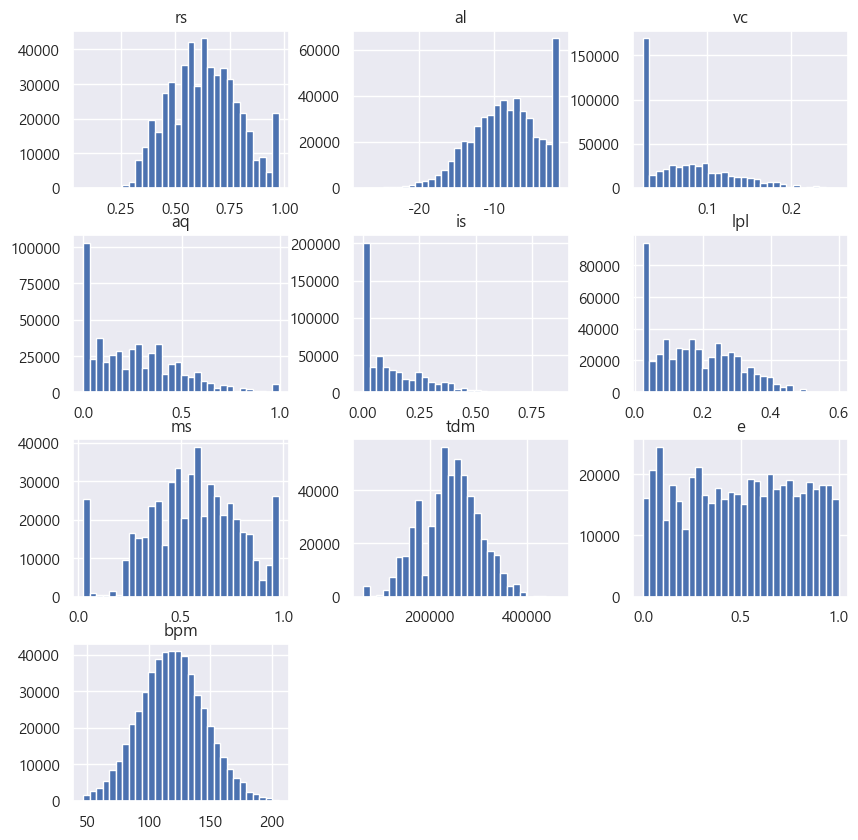

In [39]:
df.hist(figsize=(10, 10), bins=30)
plt.show()

* 오른쪽으로 심하게 치우친 변수들 (vc, aq, is, lpl, tdm)
* 왼쪽으로 치우친 변수들 (rs, al, tdm)

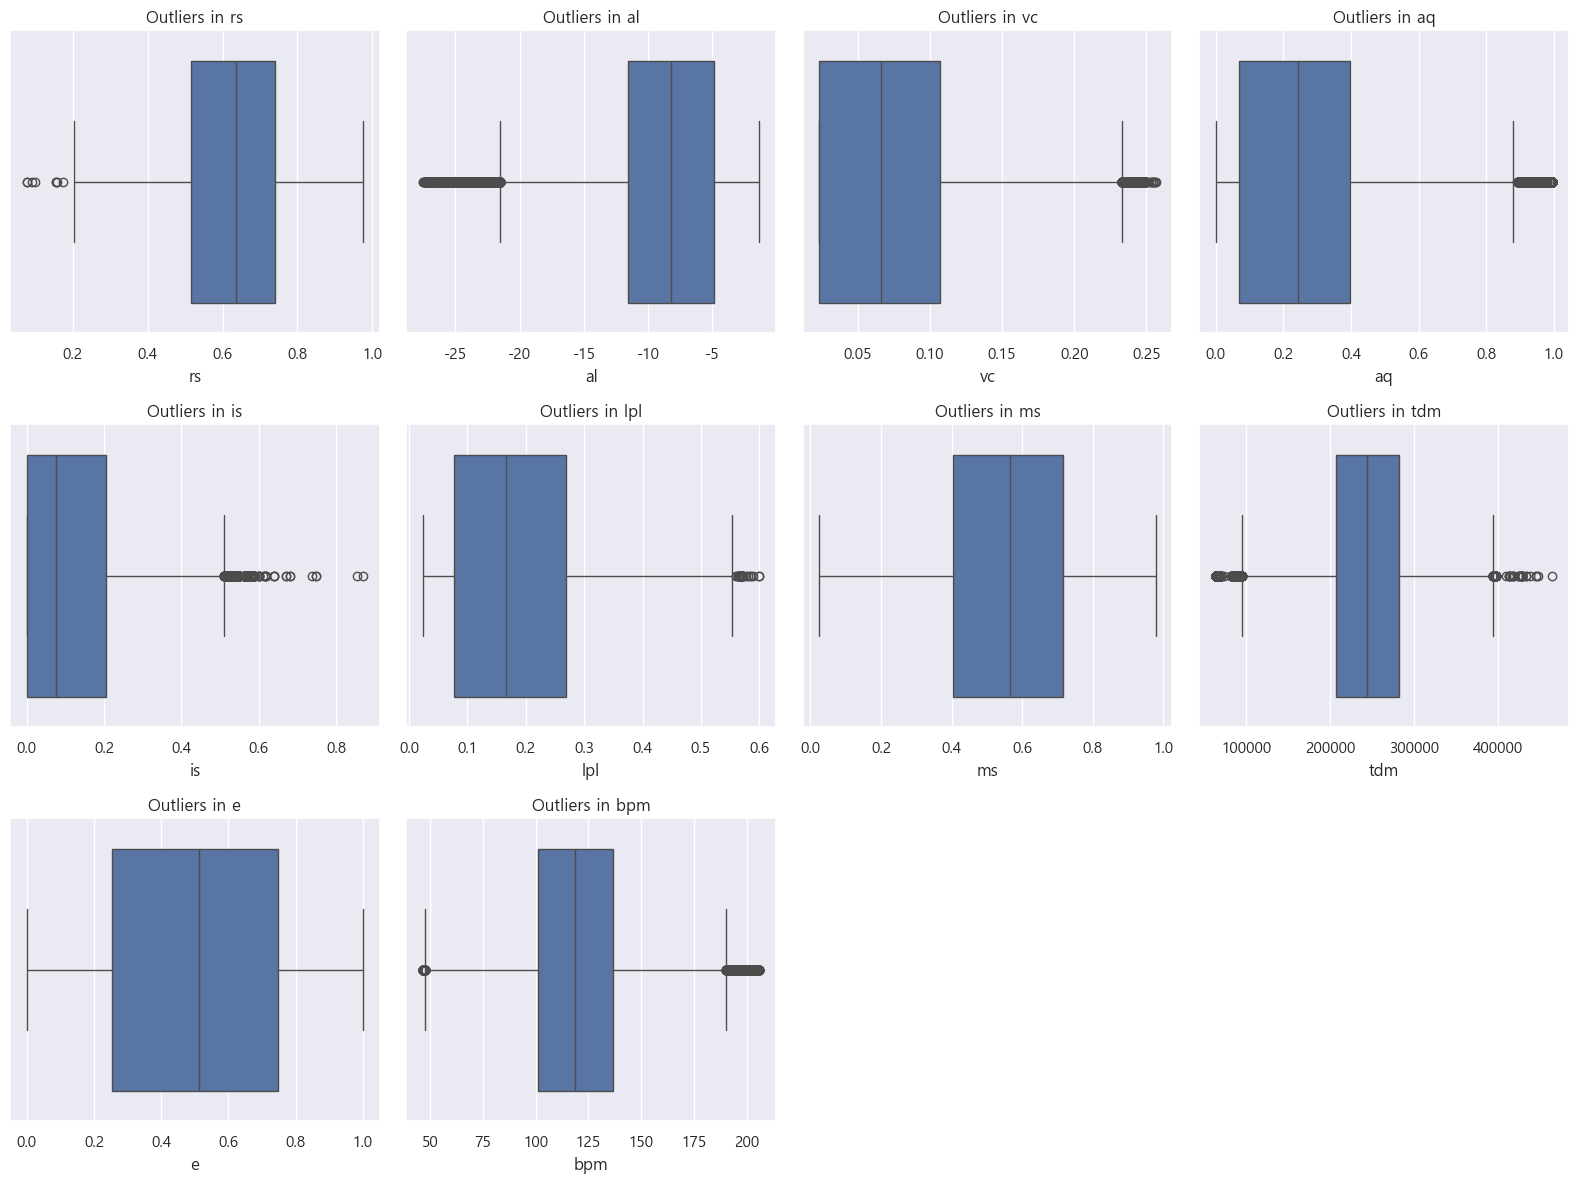

In [40]:
# 분석할 숫자형 특성들 선택
# num_features = df.columns
num_features = df.select_dtypes(include=np.number).columns.tolist()

# 1. 전체 그림의 크기와 격자(grid) 설정
n_features = len(num_features)
n_cols = 4  # 한 줄에 그릴 그래프의 개수 (원하는 대로 조절)
n_rows = math.ceil(n_features / n_cols) # 필요한 줄의 개수 자동 계산

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten() # 2차원 배열을 1차원으로 변환하여 다루기 쉽게 함

# 2. for문을 사용하여 각 subplot에 boxplot 그리기
for i, col in enumerate(num_features):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Outliers in {col}")

# 3. 남는 빈 subplot들은 보이지 않게 처리
for j in range(n_features, len(axes)):
    axes[j].axis('off')

# 4. 전체 그림을 보기 좋게 조정하고 출력
plt.tight_layout()
plt.show()

# myscore 공통함수

* 현재 RMSE 점수를 역대 최고 점수와 비교하여 최고 기록이 경신되었는지 알려주는 기능 추가
* 변수 중요도(Feature Importance)를 시각화하는 기능 추가

In [41]:
# ----------------------------------------------------
# RMSE가 가장 좋았던 점수를 저장할 변수
best_scores = None
# ----------------------------------------------------

def myscore(X80=None, y80=None, X20=None, y20=None, model=None, df=None, fi=None, top_n=None):
    """
    모델을 학습/평가하고, 가장 좋았던 RMSE 점수와 현재 점수를 비교합니다.
    fi=True일 경우 피쳐 중요도를 시각화합니다.
    """
    global best_scores
    precision = 5 # 소수점 자리수 통일

    # 데이터 분할 및 모델 학습
    if df is not None:
        y = df['bpm']
        X = df.drop('bpm', axis=1)
        X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=8989)
    if model is None:
        model = XGBRegressor(random_state=8989)
    model.fit(X80, y80)
    pred = model.predict(X20)

    # --- ✨ 수정된 부분 1: 점수 계산 시 round 적용 ---
    current_scores = {
        'MSE': round(mean_squared_error(y20, pred), precision),
        'RMSE': round(root_mean_squared_error(y20, pred), precision),
        'R2': round(r2_score(y20, pred), precision)
    }

    # --- ✨ 수정된 부분 2: 출력 형식 소수점 5자리로 변경 ---
    print(f"MODEL : {model.__class__.__name__}\n"
          f"MSE : {current_scores['MSE']:.5f}\n"
          f"RMSE : {current_scores['RMSE']:.5f}\n"
          f"R2 : {current_scores['R2']:.5f}")
    print("-" * 30)

    # 최고 기록 갱신 로직 (round가 적용되어 정확하게 비교됨)
    if best_scores is None:
        print("🚀 첫 실행입니다. 최고 점수 기준을 설정합니다.")
        best_scores = current_scores
    elif current_scores['RMSE'] < best_scores['RMSE']:
        print("🎉 New Best RMSE Score Achieved! 🎉")
        best_scores = current_scores

    # 점수 비교 출력
    print("--- Score Comparison (Current vs Best RMSE) ---")
    for key, current_val in current_scores.items():
        best_val = best_scores.get(key, 0)
        diff = round(current_val - best_val, precision) # 차이 계산에도 round 적용

        if diff == 0:
            change_indicator = "➖"
        elif key == 'R2':
            change_indicator = "📈" if diff > 0 else "📉"
        else:
            change_indicator = "📈" if diff < 0 else "📉"

        # --- ✨ 수정된 부분 3: 비교 출력 형식도 소수점 5자리로 변경 ---
        print(f'{key:<5}: {current_val:.5f} (Best: {best_val:.5f}) | Change: {diff:+.5f} {change_indicator}')

    print("-" * 30 + "\n")

    # Feature Importance 시각화 (기존과 동일)
    if fi:
        if isinstance(model, Pipeline): actual_model = model.steps[-1][1]
        else: actual_model = model
        if not hasattr(actual_model, 'feature_importances_'):
            print(f"\nNOTE: 이 모델({actual_model.__class__.__name__})은 feature_importances_ 속성이 없습니다.")
            return
        importances = actual_model.feature_importances_
        feature_names = X80.columns
        fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        fi_df = fi_df.sort_values(by='importance', ascending=False)
        title_text = f'Feature Importances ({actual_model.__class__.__name__})'
        if top_n is not None:
            fi_df = fi_df.head(top_n)
            title_text = f'Top {top_n} ' + title_text
        plt.figure(figsize=(12, 6))
        sns.barplot(x='feature', y='importance', data=fi_df)
        plt.title(title_text)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

## 첫 번째 점수 확인

MODEL : XGBRegressor
MSE : 703.14616
RMSE : 26.51690
R2 : -0.00684
------------------------------
🚀 첫 실행입니다. 최고 점수 기준을 설정합니다.
--- Score Comparison (Current vs Best RMSE) ---
MSE  : 703.14616 (Best: 703.14616) | Change: +0.00000 ➖
RMSE : 26.51690 (Best: 26.51690) | Change: +0.00000 ➖
R2   : -0.00684 (Best: -0.00684) | Change: +0.00000 ➖
------------------------------



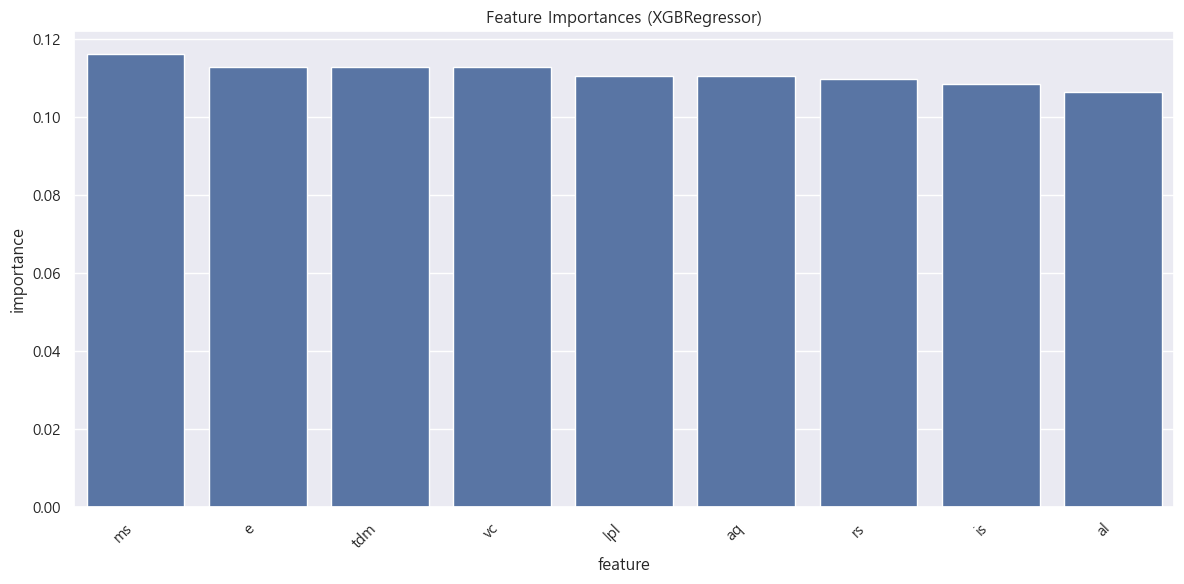

In [42]:
myscore(df = df, fi=True)

# 전처리 & 가공

## 이상치 처리

* IQR을 기준으로 이상치를 처리하는 두 가지 방법
* 첫 번째 방법은 이상치를 포함한 행 전체를 **삭제(Trimming)**
* 두 번째 방법은 이상치 값을 정상 범위의 경계값으로 **대체(Winsorization)**하여 데이터프레임의 형태는 유지

In [43]:
###########################################################
# 1. IQR 기반 이상치 행 '삭제' (Trimming) - dft 사용
###########################################################

# 원본 DataFrame을 'dft'로 안전하게 복사
dft = df.copy()

# dft에서 숫자형 특성(feature)들의 리스트를 가져옴
num_features_for_trim = dft.select_dtypes(include=np.number).columns.tolist()

print(">> Trimming Process Start")
print("Original Shape (dft):", dft.shape)

# dft의 각 숫자형 특성에 대해 이상치 행 삭제
for col in num_features_for_trim:
    Q1 = dft[col].quantile(0.25)
    Q3 = dft[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 정상 범위에 있는 행만 dft에 남김
    dft = dft[(dft[col] >= lower_bound) & (dft[col] <= upper_bound)]

# 최종 결과 확인
print("Trimmed Shape (dft):", dft.shape)
print("-" * 50)


###########################################################
# 2. IQR 기반 이상치 '대체' (Winsorization) - dfw 사용
###########################################################

# 원본 DataFrame을 'dfw'로 안전하게 복사
dfw = df.copy()

# dfw에서 숫자형 특성(feature)들의 리스트를 가져옴
num_features_for_winsorize = dfw.select_dtypes(include=np.number).columns.tolist()

print(">> Winsorization Process Start")
print("Original Shape (dfw):", dfw.shape)

# dfw의 각 숫자형 특성에 대해 이상치를 경계값으로 대체
for col in num_features_for_winsorize:
    Q1 = dfw[col].quantile(0.25)
    Q3 = dfw[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # dfw의 값을 np.where를 사용하여 대체
    dfw[col] = np.where(dfw[col] < lower_bound, lower_bound,
                        np.where(dfw[col] > upper_bound, upper_bound, dfw[col]))

# 최종 결과 확인
print("Winsorized Shape (dfw):", dfw.shape)
print("-" * 50)

>> Trimming Process Start
Original Shape (dft): (524164, 10)
Trimmed Shape (dft): (505206, 10)
--------------------------------------------------
>> Winsorization Process Start
Original Shape (dfw): (524164, 10)
Winsorized Shape (dfw): (524164, 10)
--------------------------------------------------


* 이상치 여전히 존재
* 직접 값을 찾아가며 수정 완료한 코드 있으나 여기에 아직 합치지 못 함

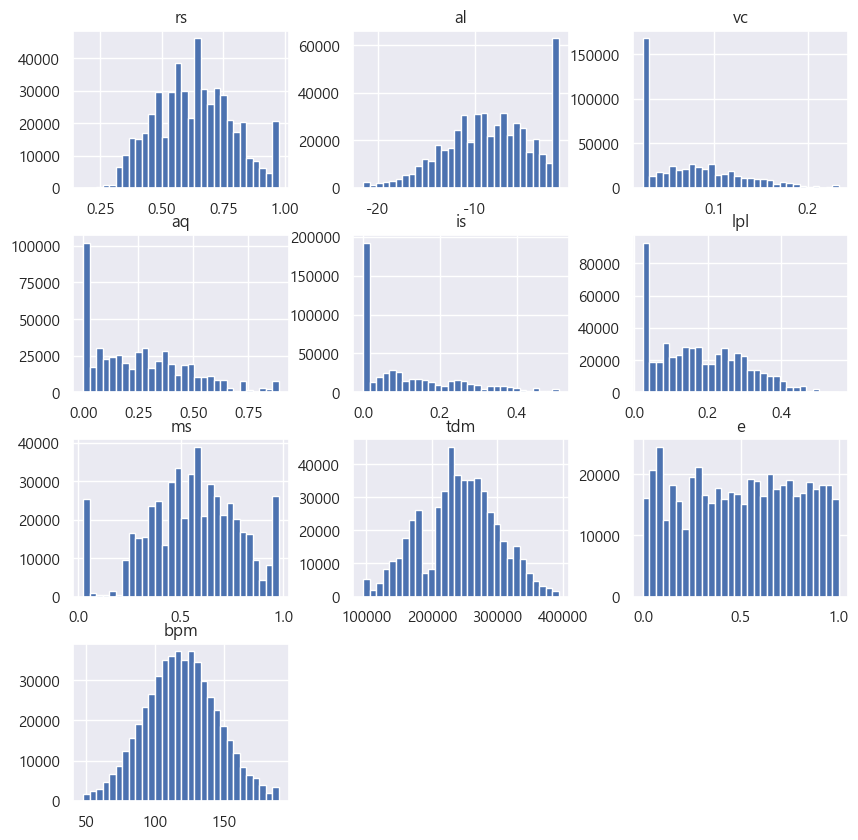

In [44]:
dfw.hist(figsize=(10, 10), bins=30)
plt.show()

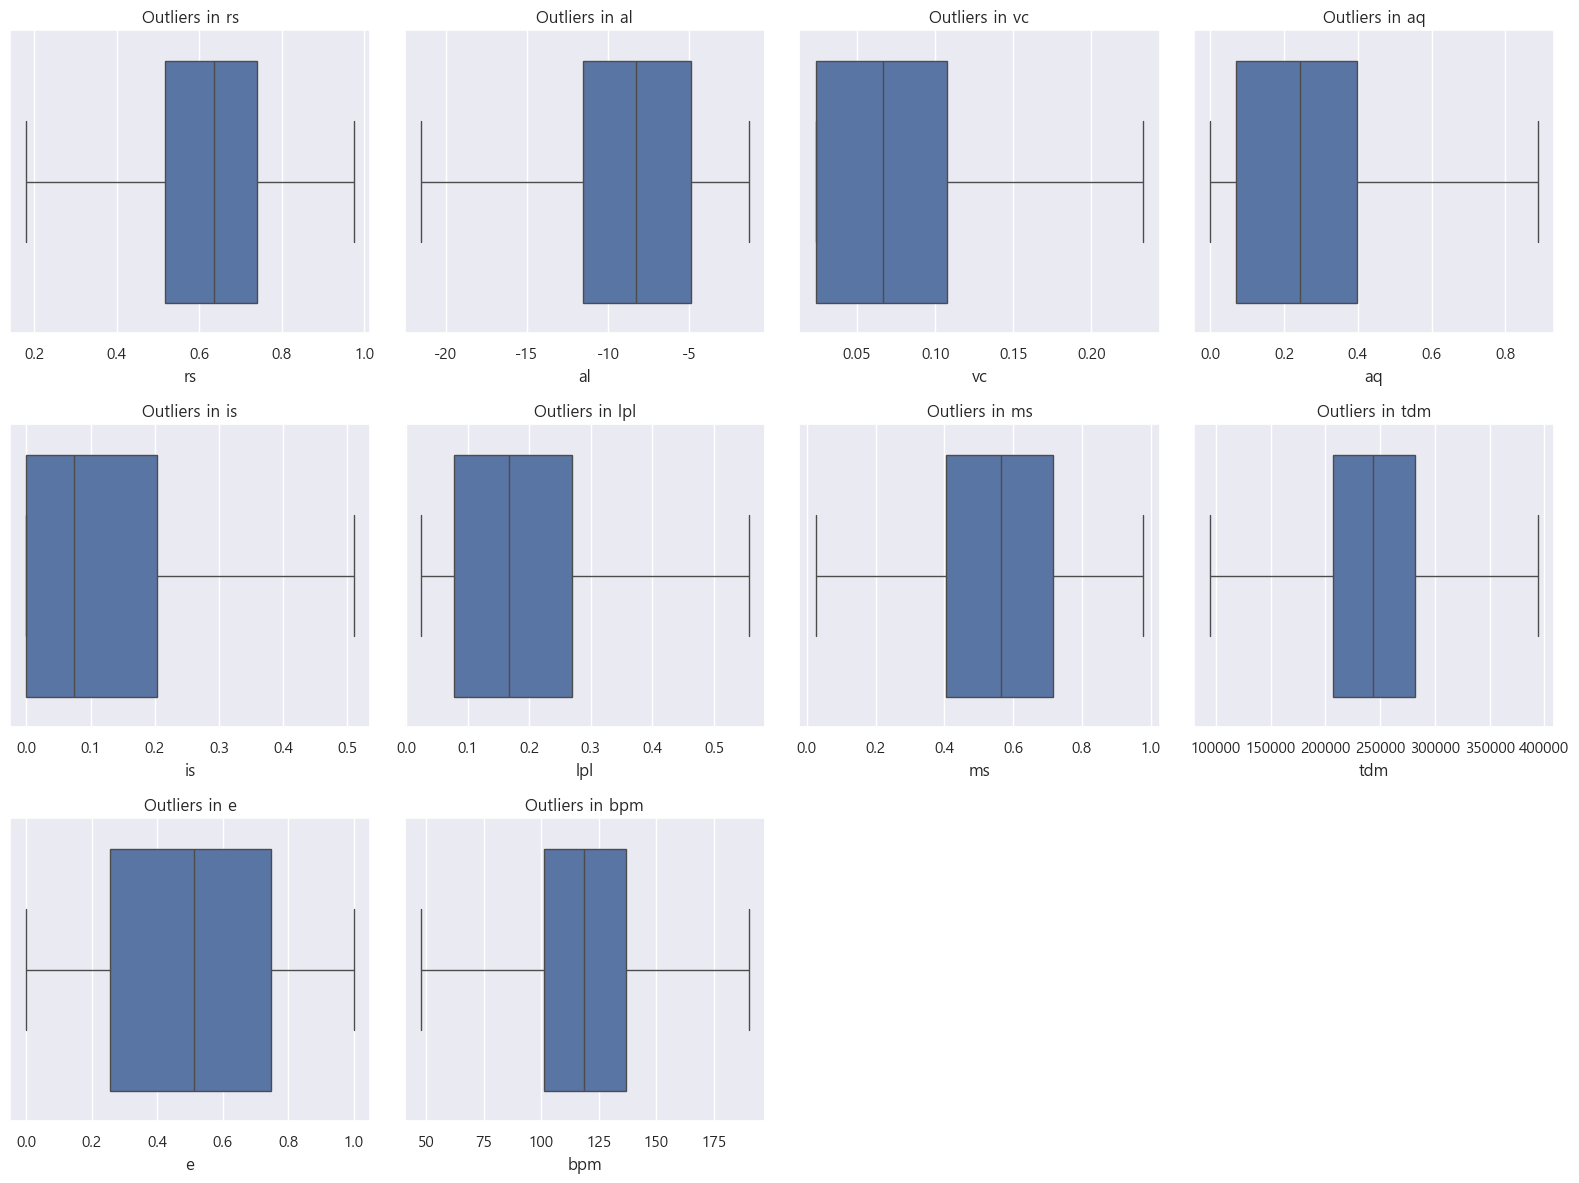

In [45]:
num_features = dfw.select_dtypes(include=np.number).columns.tolist()

# 1. 전체 그림의 크기와 격자(grid) 설정
n_features = len(num_features)
n_cols = 4  # 한 줄에 그릴 그래프의 개수 (원하는 대로 조절)
n_rows = math.ceil(n_features / n_cols) # 필요한 줄의 개수 자동 계산

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten() # 2차원 배열을 1차원으로 변환하여 다루기 쉽게 함

# 2. for문을 사용하여 각 subplot에 boxplot 그리기
for i, col in enumerate(num_features):
    sns.boxplot(x=dfw[col], ax=axes[i])
    axes[i].set_title(f"Outliers in {col}")

# 3. 남는 빈 subplot들은 보이지 않게 처리
for j in range(n_features, len(axes)):
    axes[j].axis('off')

# 4. 전체 그림을 보기 좋게 조정하고 출력
plt.tight_layout()
plt.show()

### 점수 확인

In [46]:
myscore(df = dfw)

MODEL : XGBRegressor
MSE : 700.27722
RMSE : 26.46275
R2 : -0.00786
------------------------------
🎉 New Best RMSE Score Achieved! 🎉
--- Score Comparison (Current vs Best RMSE) ---
MSE  : 700.27722 (Best: 700.27722) | Change: +0.00000 ➖
RMSE : 26.46275 (Best: 26.46275) | Change: +0.00000 ➖
R2   : -0.00786 (Best: -0.00786) | Change: +0.00000 ➖
------------------------------



## 파생 피쳐 추가

* 파생 피쳐 7가지 추가

In [47]:
dfw['tdn'] = dfw['tdm'] / 60000
dfw['ear'] = dfw['e'] / (dfw['aq'] + 1e-5)
dfw['vib'] = dfw['vc'] / (dfw['is'] + 1e-5)
dfw['mr'] = dfw['ms'] * dfw['rs']
dfw['pi'] = dfw['lpl'] * dfw['al']
dfw['re'] = dfw['rs'] * dfw['e']
dfw['ma'] = dfw['ms'] * dfw['aq']

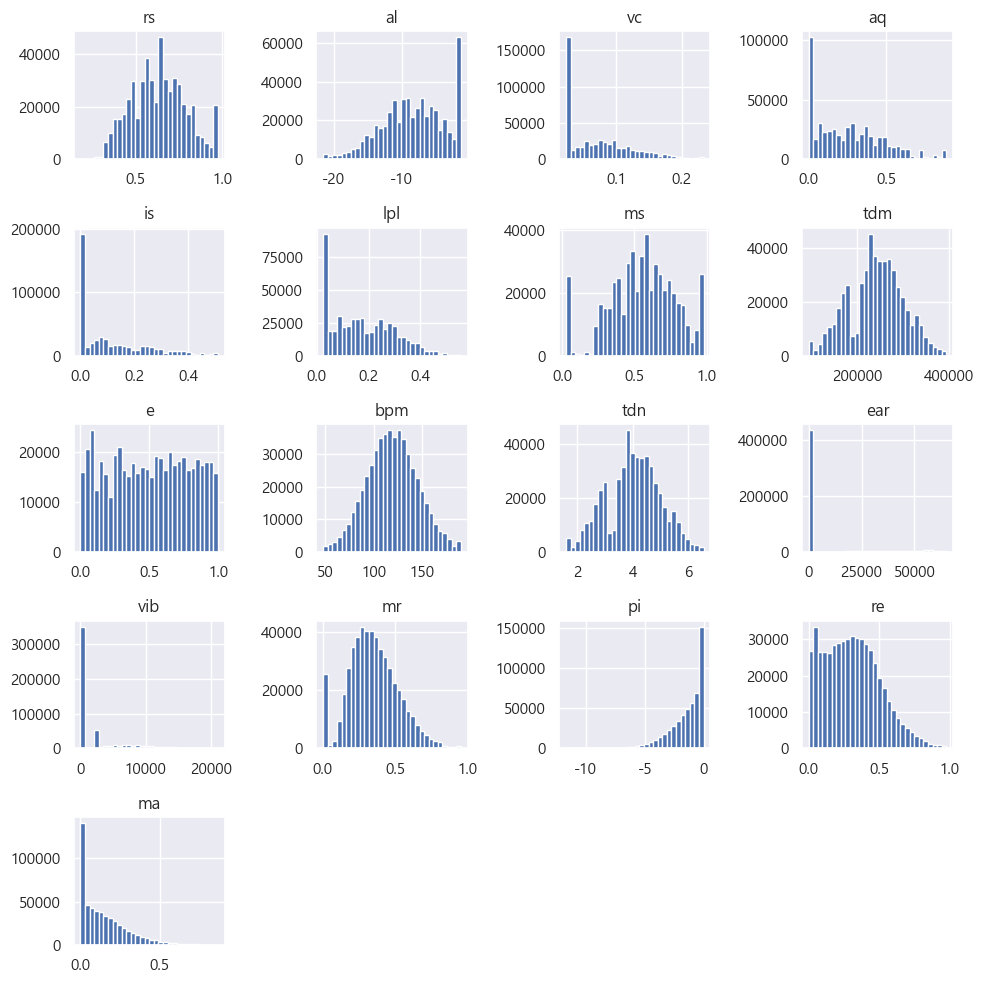

In [48]:
dfw.hist(figsize=(10, 10), bins=30)
plt.tight_layout()
plt.show()

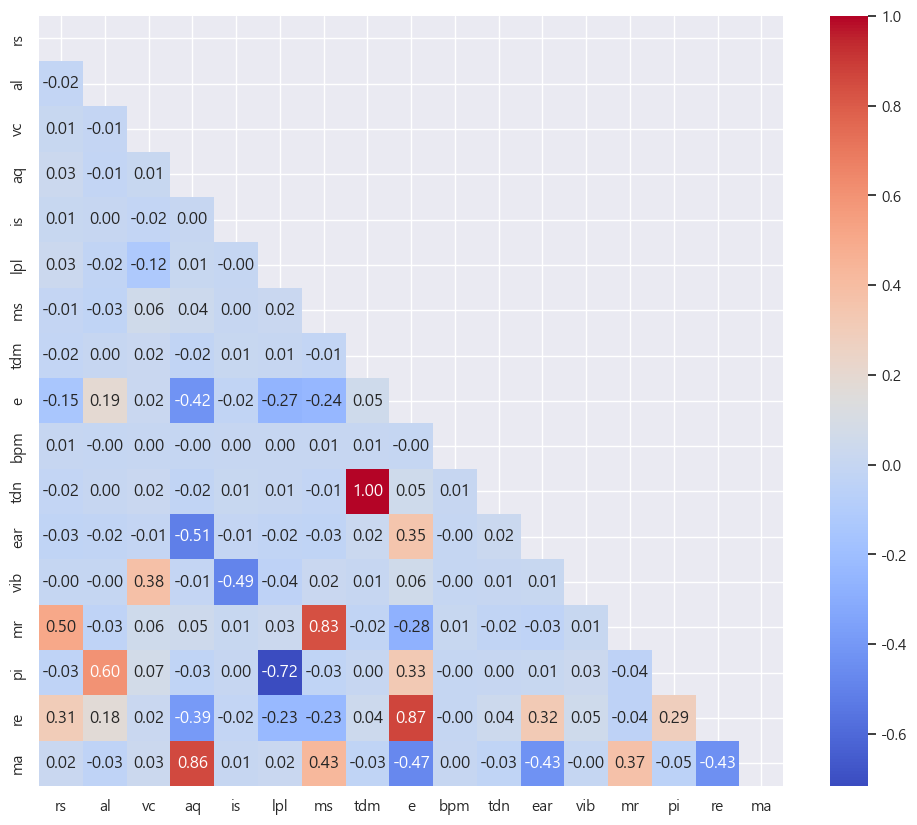

In [49]:
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(dfw.corr(), dtype=bool))
sns.heatmap(dfw.corr(), annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.show()

### 점수 확인

MODEL : XGBRegressor
MSE : 700.07974
RMSE : 26.45902
R2 : -0.00758
------------------------------
🎉 New Best RMSE Score Achieved! 🎉
--- Score Comparison (Current vs Best RMSE) ---
MSE  : 700.07974 (Best: 700.07974) | Change: +0.00000 ➖
RMSE : 26.45902 (Best: 26.45902) | Change: +0.00000 ➖
R2   : -0.00758 (Best: -0.00758) | Change: +0.00000 ➖
------------------------------



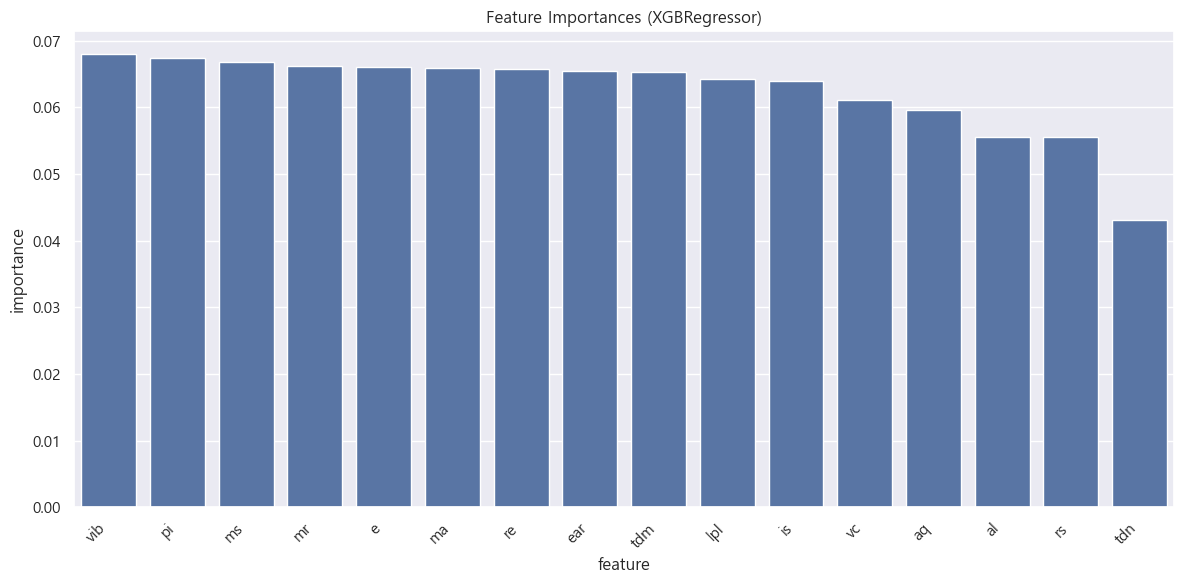

In [50]:
myscore(df = dfw, fi=True)

# 스케일 (& 점수 확인)

* XGB, LightGBM에 MinMaxScaler, RobustScaler, StandardScaler 적용
* 피쳐별로 스케일링해서 모델 학습 후, 예측 결과를 다시 inverse_transform해서 성능 평가

In [51]:
# 사용할 모델과 스케일러 리스트 정의
model_list = [XGBRegressor(),
              LGBMRegressor(verbosity=-1)]
scaler_list = [MinMaxScaler(), RobustScaler(), StandardScaler()]

# 피처(X)와 타겟(y) 분리 및 학습/테스트 데이터 분할
y = dfw['bpm']
X = dfw.drop('bpm', axis=1)
X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=8989)

# 각 스케일러별로 반복 수행
for sc in scaler_list:

    # 피처(X) 데이터 스케일링
    Xsc = sc.fit(X80)
    X80_scaler = Xsc.transform(X80)
    X20_scaler = Xsc.transform(X20)

    # 타겟(y) 데이터 스케일링
    ysc = sc.__class__()
    y80_scaler = ysc.fit_transform(y80.values.reshape(-1, 1))
    y20_scaler = ysc.fit_transform(y20.values.reshape(-1, 1))

    print(sc.__class__.__name__, '\n')
    
    # 각 모델별로 학습 및 평가 반복
    for model in model_list:
        # 스케일링된 데이터로 모델 학습 및 예측
        model.fit(X80_scaler, y80_scaler)
        pred_scaler = model.predict(X20_scaler)

        # 평가를 위해 원래 스케일로 값 복원
        y20_inv = ysc.inverse_transform(y20_scaler.reshape(-1, 1))
        pred_inv = ysc.inverse_transform(pred_scaler.reshape(-1, 1))
        
        # 성능 지표(MSE, RMSE, R2) 계산 및 출력
        mse = mean_squared_error(y20_inv, pred_inv)
        rmse = root_mean_squared_error(y20_inv, pred_inv)
        r2 = r2_score(y20_inv, pred_inv)
        print(f'MSE : {mse:.4f} RMSE : {rmse:.4f} R2 : {r2:.4f} MODEL : {model.__class__.__name__}')  
    print('--'*40, '\n')

MinMaxScaler 

MSE : 699.8316 RMSE : 26.4543 R2 : -0.0072 MODEL : XGBRegressor
MSE : 694.4922 RMSE : 26.3532 R2 : 0.0005 MODEL : LGBMRegressor
-------------------------------------------------------------------------------- 

RobustScaler 

MSE : 700.0150 RMSE : 26.4578 R2 : -0.0075 MODEL : XGBRegressor
MSE : 694.6325 RMSE : 26.3559 R2 : 0.0003 MODEL : LGBMRegressor
-------------------------------------------------------------------------------- 

StandardScaler 

MSE : 699.9008 RMSE : 26.4556 R2 : -0.0073 MODEL : XGBRegressor
MSE : 694.6939 RMSE : 26.3570 R2 : 0.0002 MODEL : LGBMRegressor
-------------------------------------------------------------------------------- 



# 중간 제출
* 이상치 & 파생피쳐 & 스케일

In [52]:
# 학습 및 테스트 데이터 로드, 테스트 ID 저장
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
test_ids = test_df['id']

# 학습 데이터 전처리: id 제거 및 컬럼명 변경
train_df = train_df.drop('id', axis=1)
train_df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e', 'bpm']

# 학습 데이터 이상치 처리 (IQR 기반 Winsorization)
numeric_features = train_df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_features:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df[col] = np.where(train_df[col] < lower_bound, lower_bound,
                             np.where(train_df[col] > upper_bound, upper_bound, train_df[col]))

# 학습 데이터에 파생 변수 추가
train_df['tdn'] = train_df['tdm'] / 60000
train_df['ear'] = train_df['e'] / (train_df['aq'] + 1e-5)
train_df['vib'] = train_df['vc'] / (train_df['is'] + 1e-5)
train_df['mr'] = train_df['ms'] * train_df['rs']
train_df['pi'] = train_df['lpl'] * train_df['al']
train_df['re'] = train_df['rs'] * train_df['e']
train_df['ma'] = train_df['ms'] * train_df['aq']

# 테스트 데이터 전처리: id 제거 및 컬럼명 변경
test_df = test_df.drop('id', axis=1)
test_df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e']

# 테스트 데이터 이상치 처리 (IQR 기반 Winsorization)
numeric_features_test = test_df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_features_test:
    Q1 = test_df[col].quantile(0.25)
    Q3 = test_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    test_df[col] = np.where(test_df[col] < lower_bound, lower_bound,
                            np.where(test_df[col] > upper_bound, upper_bound, test_df[col]))

# 테스트 데이터에 파생 변수 추가
test_df['tdn'] = test_df['tdm'] / 60000
test_df['ear'] = test_df['e'] / (test_df['aq'] + 1e-5)
test_df['vib'] = test_df['vc'] / (test_df['is'] + 1e-5)
test_df['mr'] = test_df['ms'] * test_df['rs']
test_df['pi'] = test_df['lpl'] * test_df['al']
test_df['re'] = test_df['rs'] * test_df['e']
test_df['ma'] = test_df['ms'] * test_df['aq']

# 피처(X)와 타겟(y) 데이터 준비
y_train = train_df['bpm']
X_train = train_df.drop('bpm', axis=1)
X_test = test_df.copy()

# 데이터 컬럼 순서 일치
X_test = X_test[X_train.columns]

# 최종 모델 파이프라인 정의 (피처/타겟 스케일링 + LGBM 모델)
final_model = TransformedTargetRegressor(
    regressor=Pipeline([
        ('my_scaler', MinMaxScaler()),
        ('my_model', LGBMRegressor(verbosity=-1, random_state=8989))
    ]),
    transformer=MinMaxScaler()
)

# 전체 학습 데이터로 최종 모델 훈련
final_model.fit(X_train, y_train)
print("최종 모델 학습이 완료되었습니다.")

# 테스트 데이터로 예측 수행
predictions = final_model.predict(X_test)
print("테스트 데이터에 대한 예측이 완료되었습니다.")

# 예측 결과를 submission.csv 파일로 저장
submission = pd.DataFrame({
    "id": test_ids,
    "bpm": predictions
})
submission.to_csv("submission.csv", index=False)
print("submission.csv 파일 생성이 완료되었습니다.")
print(submission.head())

최종 모델 학습이 완료되었습니다.
테스트 데이터에 대한 예측이 완료되었습니다.
submission.csv 파일 생성이 완료되었습니다.
       id         bpm
0  524164  119.823408
1  524165  119.154888
2  524166  121.159489
3  524167  119.279225
4  524168  119.822438


# 파이프라인 (로그 + 스케일)

* 로그 변환과 StandardScaler를 둘 다 적용 후 XGB로 학습

In [53]:
y = dfw['bpm']
X = dfw.drop('bpm', axis=1)
X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=8989)

tran_pipe = TransformedTargetRegressor (
                Pipeline([ ('my_log1p', FunctionTransformer(np.log1p, validate=True)), 
                           ('my_scaler', StandardScaler()),
                           ('my_model', XGBRegressor())
                       ]),
                func=np.log1p, 
                inverse_func=np.expm1
)

## 점수 확인

In [54]:
myscore(df=dfw, model=tran_pipe)

MODEL : TransformedTargetRegressor
MSE : 709.58448
RMSE : 26.63803
R2 : -0.02126
------------------------------
--- Score Comparison (Current vs Best RMSE) ---
MSE  : 709.58448 (Best: 700.07974) | Change: +9.50474 📉
RMSE : 26.63803 (Best: 26.45902) | Change: +0.17901 📉
R2   : -0.02126 (Best: -0.00758) | Change: -0.01368 📉
------------------------------



## 중간 제출
* 이상치 & 파생피쳐 & 로그 + 스케일

In [55]:
# 학습 및 테스트 데이터 로드, 테스트 ID 저장
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
test_ids = test_df['id']

# 데이터 전처리 함수 정의
def preprocess_data(df):
    
    # id 제거 및 컬럼명 변경
    if 'BeatsPerMinute' in df.columns or 'bpm' in df.columns:
        df = df.drop('id', axis=1)
        df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e', 'bpm']
    else:
        df = df.drop('id', axis=1)
        df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e']

    # 이상치 처리 (IQR 기반 Winsorization), 타겟 변수 제외
    numeric_features = df.select_dtypes(include=np.number).columns.tolist()
    if 'bpm' in numeric_features:
        numeric_features.remove('bpm')

    for col in numeric_features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound,
                           np.where(df[col] > upper_bound, upper_bound, df[col]))
    
    # 파생 변수 추가
    df['tdn'] = df['tdm'] / 60000
    df['ear'] = df['e'] / (df['aq'] + 1e-5)
    df['vib'] = df['vc'] / (df['is'] + 1e-5)
    df['mr'] = df['ms'] / (df['rs'] + 1e-5)
    df['pi'] = df['lpl'] * df['al']
    df['re'] = df['rs'] * df['e']
    df['ma'] = df['ms'] * df['aq']
    
    return df

# 정의된 함수를 사용해 데이터 전처리 적용
train_processed_df = preprocess_data(train_df.copy())
test_processed_df = preprocess_data(test_df.copy())

# 피처(X)와 타겟(y) 데이터 준비
y_train = train_processed_df['bpm']
X_train = train_processed_df.drop(columns=['bpm'])

# 피처/타겟 로그 변환, 스케일링을 포함한 XGBoost 모델 파이프라인 정의
final_model = TransformedTargetRegressor(
    regressor=Pipeline([
        ('my_log1p', FunctionTransformer(np.log1p, validate=False)),
        ('my_scaler', StandardScaler()),
        ('my_model', XGBRegressor(random_state=8989))
    ]),
    func=np.log1p,
    inverse_func=np.expm1
)

# 전체 학습 데이터로 최종 모델 훈련
final_model.fit(X_train, y_train)
print("최종 모델 학습이 완료되었습니다.")

# 테스트 데이터의 컬럼 순서를 학습 데이터와 일치
train_features = X_train.columns
X_test_final = test_processed_df[train_features]

# 테스트 데이터로 예측 수행
predictions = final_model.predict(X_test_final)

# 예측 결과를 submission.csv 파일로 저장
submission = pd.DataFrame({
    "id": test_ids,
    "bpm": predictions
})
submission.to_csv("submission.csv", index=False)
print("submission.csv 파일 생성이 완료되었습니다.")
print(submission.head())

최종 모델 학습이 완료되었습니다.
submission.csv 파일 생성이 완료되었습니다.
       id         bpm
0  524164  115.947258
1  524165  114.794853
2  524166  117.064171
3  524167  118.302979
4  524168  119.895798


# 특정 피쳐만 로그 변환

* 왜도가 심했던 피쳐만 로그 변환 적용
* 변환한 뒤 스케일링해서 XGB로 학습시키는 파이프라인

In [56]:
# # 피처(X)와 타겟(y) 분리 및 학습/테스트 데이터 분할
# y = dfw['bpm']
# X = dfw.drop('bpm', axis=1)
# X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=8989)

# # 로그 변환을 적용할 피처 목록 정의
# log_features = ['vc', 'aq', 'is']

# # 특정 피처에만 로그 변환을 적용하는 전처리 파이프라인
# feature_pipe = ColumnTransformer([
#     ('log_transform', FunctionTransformer(np.log1p, validate=True), log_features),
#     ('pass', 'passthrough', [col for col in X80.columns if col not in log_features])
# ])

# # 피처 변환, 스케일링, 모델을 순차적으로 실행하는 전체 모델 파이프라인
# model = Pipeline([
#     ('feature_pipe', feature_pipe),
#     ('scaler', StandardScaler()),
#     ('xgb', XGBRegressor())
# ])

# # 모델 파이프라인에 타겟(y) 로그 변환 및 자동 역변환 기능 추가
# tran_pipe2 = TransformedTargetRegressor(
#     regressor=model,
#     func=np.log1p,
#     inverse_func=np.expm1
# )

## 점수 확인

In [57]:
# myscore(df=dfw, model=tran_pipe2)

# 스태킹

* XGB와 LGBM으로 스태킹

In [58]:
# # GPU 사용으로 설정된 기반 모델(XGBoost, LightGBM) 정의
# xgb = XGBRegressor(
#      n_estimators=500,
#      learning_rate=0.05,
#      max_depth=6,
#      subsample=0.8,
#      colsample_bytree=0.8,
#      random_state=42,
#      n_jobs=-1,
#      tree_method='gpu_hist',
#      predictor='gpu_predictor'
# )
# lgbm = LGBMRegressor(
#      n_estimators=500,
#      learning_rate=0.05,
#      num_leaves=31,
#      subsample=0.8,
#      colsample_bytree=0.8,
#      random_state=42,
#      n_jobs=-1,
#      device='gpu'
# )

# # 메타 모델(RidgeCV) 정의
# meta_model = RidgeCV(alphas=np.logspace(-3, 3, 7))

# # 기반 모델과 메타 모델을 결합한 스태킹 앙상블 모델 생성
# stack_model = StackingRegressor(
#      estimators=[
#          ("xgb", xgb),
#          ("lgbm", lgbm)
#      ],
#      final_estimator=meta_model,
#      passthrough=False,
#      n_jobs=-1
# )

# # 스태킹 모델 학습 및 예측 수행
# stack_model.fit(X80, y80)
# pred = stack_model.predict(X20)

# # MSE(평균 제곱 오차)로 모델 성능 평가 및 출력
# mse = mean_squared_error(y20, pred)
# print("Stacking MSE:", mse)

## 점수 확인

In [59]:
# myscore(df=dfw)

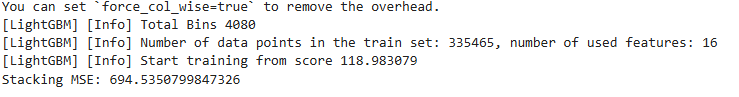

In [60]:
np.sqrt(694.5350799847326)

np.float64(26.354033467094418)

# 규제 (& 점수 확인)

* elasticnet으로 규제

In [61]:
# 테스트할 alpha 값 리스트 정의
alphas = [0.01, 0.1, 1, 10, 100]

print("===== ElasticNet Hyperparameter Tuning with myscore =====")

# 각 alpha 값에 대해 반복 수행
for alpha_value in alphas:
    print(f"\nTesting alpha = {alpha_value}")

    # 데이터 스케일링과 ElasticNet 모델을 포함하는 파이프라인 생성
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(alpha=alpha_value, random_state=8989))
    ])
    
    # myscore 함수를 사용하여 현재 파이프라인의 성능 평가
    myscore(X80=X80, y80=y80, X20=X20, y20=y20, model=pipeline)

===== ElasticNet Hyperparameter Tuning with myscore =====

Testing alpha = 0.01
MODEL : Pipeline
MSE : 694.66691
RMSE : 26.35653
R2 : 0.00021
------------------------------
🎉 New Best RMSE Score Achieved! 🎉
--- Score Comparison (Current vs Best RMSE) ---
MSE  : 694.66691 (Best: 694.66691) | Change: +0.00000 ➖
RMSE : 26.35653 (Best: 26.35653) | Change: +0.00000 ➖
R2   : 0.00021 (Best: 0.00021) | Change: +0.00000 ➖
------------------------------


Testing alpha = 0.1
MODEL : Pipeline
MSE : 694.70116
RMSE : 26.35718
R2 : 0.00016
------------------------------
--- Score Comparison (Current vs Best RMSE) ---
MSE  : 694.70116 (Best: 694.66691) | Change: +0.03425 📉
RMSE : 26.35718 (Best: 26.35653) | Change: +0.00065 📉
R2   : 0.00016 (Best: 0.00021) | Change: -0.00005 📉
------------------------------


Testing alpha = 1
MODEL : Pipeline
MSE : 694.81499
RMSE : 26.35934
R2 : -0.00000
------------------------------
--- Score Comparison (Current vs Best RMSE) ---
MSE  : 694.81499 (Best: 694.66691)

## 중간 제출
* 이상치 & 파생피쳐 & 스케일 & 규제

In [62]:
# 학습 및 테스트 데이터 로드, 테스트 ID 저장
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
test_ids = test_df['id']

# 학습 데이터 전처리: id 제거 및 컬럼명 변경
train_df = train_df.drop('id', axis=1)
train_df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e', 'bpm']

# 학습 데이터 이상치 처리 (IQR 기반 Winsorization)
numeric_features = train_df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_features:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df[col] = np.where(train_df[col] < lower_bound, lower_bound,
                             np.where(train_df[col] > upper_bound, upper_bound, train_df[col]))

# 학습 데이터에 파생 변수 추가
train_df['tdn'] = train_df['tdm'] / 60000
train_df['ear'] = train_df['e'] / (train_df['aq'] + 1e-5)
train_df['vib'] = train_df['vc'] / (train_df['is'] + 1e-5)
train_df['mr'] = train_df['ms'] * train_df['rs']
train_df['pi'] = train_df['lpl'] * train_df['al']
train_df['re'] = train_df['rs'] * train_df['e']
train_df['ma'] = train_df['ms'] * train_df['aq']

# 테스트 데이터 전처리: id 제거 및 컬럼명 변경
test_df = test_df.drop('id', axis=1)
test_df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e']

# 테스트 데이터 이상치 처리 (IQR 기반 Winsorization)
numeric_features_test = test_df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_features_test:
    Q1 = test_df[col].quantile(0.25)
    Q3 = test_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    test_df[col] = np.where(test_df[col] < lower_bound, lower_bound,
                            np.where(test_df[col] > upper_bound, upper_bound, test_df[col]))

# 테스트 데이터에 파생 변수 추가
test_df['tdn'] = test_df['tdm'] / 60000
test_df['ear'] = test_df['e'] / (test_df['aq'] + 1e-5)
test_df['vib'] = test_df['vc'] / (test_df['is'] + 1e-5)
test_df['mr'] = test_df['ms'] * test_df['rs']
test_df['pi'] = test_df['lpl'] * test_df['al']
test_df['re'] = test_df['rs'] * test_df['e']
test_df['ma'] = test_df['ms'] * test_df['aq']

# 피처(X)와 타겟(y) 데이터 준비
y_train = train_df['bpm']
X_train = train_df.drop('bpm', axis=1)
X_test = test_df.copy()

# 데이터 컬럼 순서 일치
X_test = X_test[X_train.columns]

# 피처/타겟 스케일링을 포함한 ElasticNet 모델 파이프라인 정의
final_model = TransformedTargetRegressor(
    regressor=Pipeline([
        ('my_scaler', StandardScaler()),
        ('my_model', ElasticNet(alpha=0.01, random_state=8989))
    ]),
    transformer=StandardScaler()
)

# 전체 학습 데이터로 최종 모델 훈련
final_model.fit(X_train, y_train)
print("최종 모델 학습이 완료되었습니다.")

# 테스트 데이터로 예측 수행
predictions = final_model.predict(X_test)
print("테스트 데이터에 대한 예측이 완료되었습니다.")

# 예측 결과를 submission.csv 파일로 저장
submission = pd.DataFrame({
    "id": test_ids,
    "bpm": predictions
})
submission.to_csv("submission.csv", index=False)
print("submission.csv 파일 생성이 완료되었습니다.")
print(submission.head())

최종 모델 학습이 완료되었습니다.
테스트 데이터에 대한 예측이 완료되었습니다.
submission.csv 파일 생성이 완료되었습니다.
       id         bpm
0  524164  119.008836
1  524165  119.018824
2  524166  119.010877
3  524167  119.093369
4  524168  119.060148


# 피쳐 셀렉션

* SelectFromModel로 피쳐 셀렉션

In [63]:
# 피처(X)와 타겟(y) 데이터 분리
y = dfw['bpm']
X = dfw.drop('bpm', axis=1)

# Ridge 모델을 평가 기준으로 사용하는 피처 선택 객체 생성
# 중요도(계수)가 중앙값(median) 이상인 피처만 선택하도록 설정
selector = SelectFromModel(
    estimator=Ridge(alpha=1.0), 
    threshold='median'
)

# 데이터를 사용하여 피처 선택기 학습
selector.fit(X, y)

# 선택된 피처의 이름 확인 및 출력
selected_features_mask = selector.get_support()
selected_features = X.columns[selected_features_mask]
print(f"총 {len(X.columns)}개의 피쳐 중 {len(selected_features)}개가 선택되었습니다.")
print("\n[선택된 피쳐 목록]")
print(list(selected_features))

# 선택된 피처만으로 원본 데이터를 변환하고 형태 출력
X_selected = selector.transform(X)
print(f"\n원본 데이터 형태: {X.shape}")
print(f"피쳐 선택 후 데이터 형태: {X_selected.shape}")

총 16개의 피쳐 중 8개가 선택되었습니다.

[선택된 피쳐 목록]
['rs', 'vc', 'aq', 'lpl', 'ms', 'e', 'mr', 're']

원본 데이터 형태: (524164, 16)
피쳐 선택 후 데이터 형태: (524164, 8)


## 중간 제출
* 이상치 & 파생피쳐 & 스케일 & 규제 & 피쳐셀렉션

In [64]:
# 학습 및 테스트 데이터 로드, 테스트 ID 저장
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
test_ids = test_df['id']

# 데이터 전처리 함수 정의
def preprocess_data(df, is_train=True):
    # id 제거 및 컬럼명 변경
    df = df.drop('id', axis=1)
    if is_train:
        df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e', 'bpm']
    else:
        df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e']
    
    # 이상치 처리 (IQR 기반 Winsorization), 타겟 변수 제외
    numeric_features = df.select_dtypes(include=np.number).columns.tolist()
    if 'bpm' in numeric_features:
        numeric_features.remove('bpm')

    for col in numeric_features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound,
                           np.where(df[col] > upper_bound, upper_bound, df[col]))
    
    # 파생 변수 추가
    df['tdn'] = df['tdm'] / 60000
    df['ear'] = df['e'] / (df['aq'] + 1e-5)
    df['vib'] = df['vc'] / (df['is'] + 1e-5)
    df['mr'] = df['ms'] * df['rs']
    df['pi'] = df['lpl'] * df['al']
    df['re'] = df['rs'] * df['e']
    df['ma'] = df['ms'] * df['aq']
    
    return df

# 정의된 함수를 사용해 데이터 전처리 적용
train_processed_df = preprocess_data(train_df.copy(), is_train=True)
test_processed_df = preprocess_data(test_df.copy(), is_train=False)

# 학습 데이터에서 피처(X)와 타겟(y) 분리
y_train_full = train_processed_df['bpm']
X_train_full = train_processed_df.drop('bpm', axis=1)

# Ridge 모델 기반의 피처 선택 객체 생성
selector = SelectFromModel(
    estimator=Ridge(alpha=1.0), 
    threshold='median'
)

# 전체 학습 데이터로 피처 선택기 학습 및 선택된 피처 이름 추출
selector.fit(X_train_full, y_train_full)
selected_features = X_train_full.columns[selector.get_support()]
print(f"총 {len(X_train_full.columns)}개의 피쳐 중 {len(selected_features)}개가 선택되었습니다.")
print("선택된 피쳐:", list(selected_features))

# 선택된 피처만으로 학습 및 테스트 데이터 재구성
X_train_selected = X_train_full[selected_features]
X_test_selected = test_processed_df[selected_features]

# 피처/타겟 스케일링을 포함한 최종 LGBM 모델 파이프라인 정의
final_model = TransformedTargetRegressor(
    regressor=Pipeline([
        ('my_scaler', MinMaxScaler()),
        ('my_model', LGBMRegressor(verbosity=-1, random_state=8989))
    ]),
    transformer=MinMaxScaler()
)

# 선택된 피처만 사용하여 최종 모델 훈련
final_model.fit(X_train_selected, y_train_full)
print("\n최종 모델 학습이 완료되었습니다.")

# 테스트 데이터로 예측 수행
predictions = final_model.predict(X_test_selected)
print("테스트 데이터에 대한 예측이 완료되었습니다.")

# 예측 결과를 submission.csv 파일로 저장
submission = pd.DataFrame({
    "id": test_ids,
    "bpm": predictions
})
submission.to_csv("submission.csv", index=False)
print("submission.csv 파일 생성이 완료되었습니다.")
print(submission.head())

총 16개의 피쳐 중 8개가 선택되었습니다.
선택된 피쳐: ['rs', 'vc', 'aq', 'lpl', 'ms', 'e', 'mr', 're']

최종 모델 학습이 완료되었습니다.
테스트 데이터에 대한 예측이 완료되었습니다.
submission.csv 파일 생성이 완료되었습니다.
       id         bpm
0  524164  119.062453
1  524165  118.892675
2  524166  118.809767
3  524167  119.163531
4  524168  119.195157


# 튜닝

In [65]:
# # PyCaret용 데이터 준비
# data = dfw.copy()

# # PyCaret 실험 환경 설정 및 초기화
# print("Setting up PyCaret environment...")
# s = setup(data=data, target='bpm', session_id=8989)

# # 기본 LightGBM 모델 생성 및 교차 검증 평가
# print("\nCreating LightGBM model...")
# lightgbm = create_model('lightgbm')

# # 생성된 모델의 하이퍼파라미터 자동 튜닝
# print("\nTuning LightGBM model...")
# tuned_lightgbm = tune_model(lightgbm)

# # 튜닝된 최적 모델을 전체 데이터로 재학습
# print("\nFinalizing the tuned model...")
# final_model = finalize_model(tuned_lightgbm)

# # 최종 확정된 모델의 파라미터 확인
# print("\nFinal Tuned Model:")
# print(final_model)

# 캐글 GPU 혹사 버전

* XGB와 LGBM을 기반 모델로, Ridge를 메타 모델로 사용하는 스태킹 앙상블 사용
* 하이퍼파라미터 튜닝을 위해 RandomizedSearchCV와 KFold 교차 검증
* 모델 평가는 RMSE 점수를 기준으로 가장 좋은 조합을 탐색

In [66]:
# # GPU 사용으로 설정된 기반 모델(XGBoost, LightGBM) 정의
# xgb = XGBRegressor(
#      random_state=42,
#      n_estimators=300,
#      learning_rate=0.05,
#      max_depth=6,
#      tree_method="hist",
#      device='cuda'
# )
# lgb = LGBMRegressor(
#      boosting_type="gbdt",
#      random_state=42,
#      n_estimators=300,
#      learning_rate=0.05,
#      max_depth=-1,
#      force_col_wise=True,
#      n_jobs=1,
#      verbose=-1,
#      device_type='gpu'
# )

# # 메타 모델(RidgeCV) 정의
# meta_model = RidgeCV(alphas=np.logspace(-3, 3, 7))

# # 기반 모델과 메타 모델을 결합한 스태킹 앙상블 모델 생성
# stack = StackingRegressor(
#      estimators=[
#          ('xgb', xgb),
#          ('lgb', lgb)
#      ],
#      final_estimator=meta_model,
#      n_jobs=-1
# )

# # 튜닝할 하이퍼파라미터 탐색 공간 정의
# param_dist = {
#      'xgb__max_depth': [4, 6, 8],
#      'xgb__learning_rate': [0.03, 0.05, 0.1],
#      'lgb__learning_rate': [0.03, 0.05, 0.1],
# }

# # 교차 검증(KFold) 전략 설정
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # RandomizedSearchCV를 사용한 하이퍼파라미터 탐색 설정
# grid = RandomizedSearchCV(
#      estimator=stack,
#      param_distributions=param_dist,
#      n_iter=5,
#      scoring='neg_root_mean_squared_error',
#      cv=kf,
#      verbose=1,
#      n_jobs=1,
#      refit=True,
#      random_state=42
# )
# print("학습중")

# # CPU 데이터로 RandomizedSearchCV 모델 학습
# X80_cpu = X80.copy()
# grid.fit(X80_cpu, y80)

# # 최적 파라미터 및 최고 점수 출력
# print("✅ Best Params:", grid.best_params_)
# print("✅ Best Score (RMSE):", -grid.best_score_)

# # 최적 모델로 예측 및 성능 평가
# best_model = grid.best_estimator_
# X20_gpu = cudf.DataFrame.from_pandas(X20)
# pred = best_model.predict(X20)
# rmse = mean_squared_error(y20, pred, squared=False)
# r2 = r2_score(y20, pred)
# print(f"Validation RMSE: {rmse:.4f}")
# print(f"R² Score: {r2:.4f}")

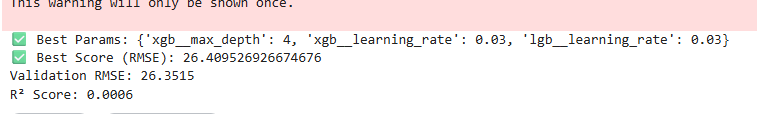